# Using Likelihood to Measure Similarity
GPT rating distributions can have any desired sample size (in this case, 100), but the human ratings typically only have a sample size of around 10-20 per word. Because of this, maybe comparing distribution shapes was never a good way to measure similarity.

A better way might be to do some kind of likelihood estimation:
- Collect 100 GPT ratings for each word
- Go through each human rating for the word, and calculate the probability of receiving this rating, given the GPT distribution.
- Gather the overall likelihood of receiving the human rating distribution, given the GPT distribution.
- Compare this to the "null" likelihood of recieving the human rating distribution given a uniform distribution.
- Determine if the GPT-likelihood is significantly higher than the null likelihood.

In [14]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

In [35]:
def safe_int_convert(string):
    """
    Convert a string to an integer, but return nan if it errors.
    """
    try:
        return int(float(string))
    except:
        return np.nan

def get_human_ratings(filename):
    """
    Collect human ratings using the CSV filename.
    """
    human_ratings = pd.read_csv(filename)
    human_ratings = human_ratings[['word', 'Response']]
    human_ratings.columns = ['word', 'rating']
    wordlist = human_ratings['word'].unique()
    wordlist = wordlist[wordlist != "This is a test; click 1."]
    human_ratings = human_ratings[human_ratings['word'].isin(wordlist)]
    return human_ratings, wordlist

def get_gpt_ratings(filename):
    """
    Take in the GPT ratings CSV (the cache file) and convert this into readable ratings.
    Safely convert strings to ints, drop nans, and ensure the ratings stay between 1 and 7.
    """
    gpt_ratings = pd.read_csv(filename)
    gpt_ratings['rating'] = gpt_ratings['rating'].apply(safe_int_convert)
    gpt_ratings = gpt_ratings.dropna()
    gpt_ratings['rating'] = np.clip(gpt_ratings['rating'], 1, 7)
    return gpt_ratings

def plot_random_words(human_filename, gpt_filename):
    """
    Pick 12 random words, and plot the human and GPT distributions overlayed with each other.
    Mark the means of each distribution.
    """
    human_ratings, wordlist = get_human_ratings(human_filename)
    gpt_ratings = get_gpt_ratings(gpt_filename)
    
    # Randomly select 12 unique ratings for plotting
    selected_words = np.random.choice(wordlist, size=12, replace=False)

    plt.figure(figsize=(15, 10))

    # Prepare bins for histograms
    bins=range(1, 9)
    
    for i, word in enumerate(selected_words, 1):

        plt.subplot(3, 4, i)  # 3 rows, 4 columns of subplots
        subset_human = human_ratings[human_ratings['word'] == word]
        subset_gpt = gpt_ratings[gpt_ratings['word'] == word]

        # Plot the histograms
        plt.hist(subset_human['rating'], color='red', alpha=0.5, bins=bins, align='left')
        plt.hist(subset_gpt['rating'], color='blue', alpha=0.5, bins=bins, align='left')

        # Calculate and plot the mean for human ratings
        human_mean = subset_human['rating'].mean()
        plt.axvline(human_mean, color='red', linestyle='dashed', linewidth=2, label=f'Human Mean: {human_mean:.2f}')

        # Calculate and plot the mean for GPT ratings
        gpt_mean = subset_gpt['rating'].mean()
        plt.axvline(gpt_mean, color='blue', linestyle='dashed', linewidth=2, label=f'GPT Mean: {gpt_mean:.2f}')

        # Set the title and limits
        plt.title(word)
        plt.xlim(0.5, 7.5)
        plt.legend()

    plt.tight_layout()
    plt.show()

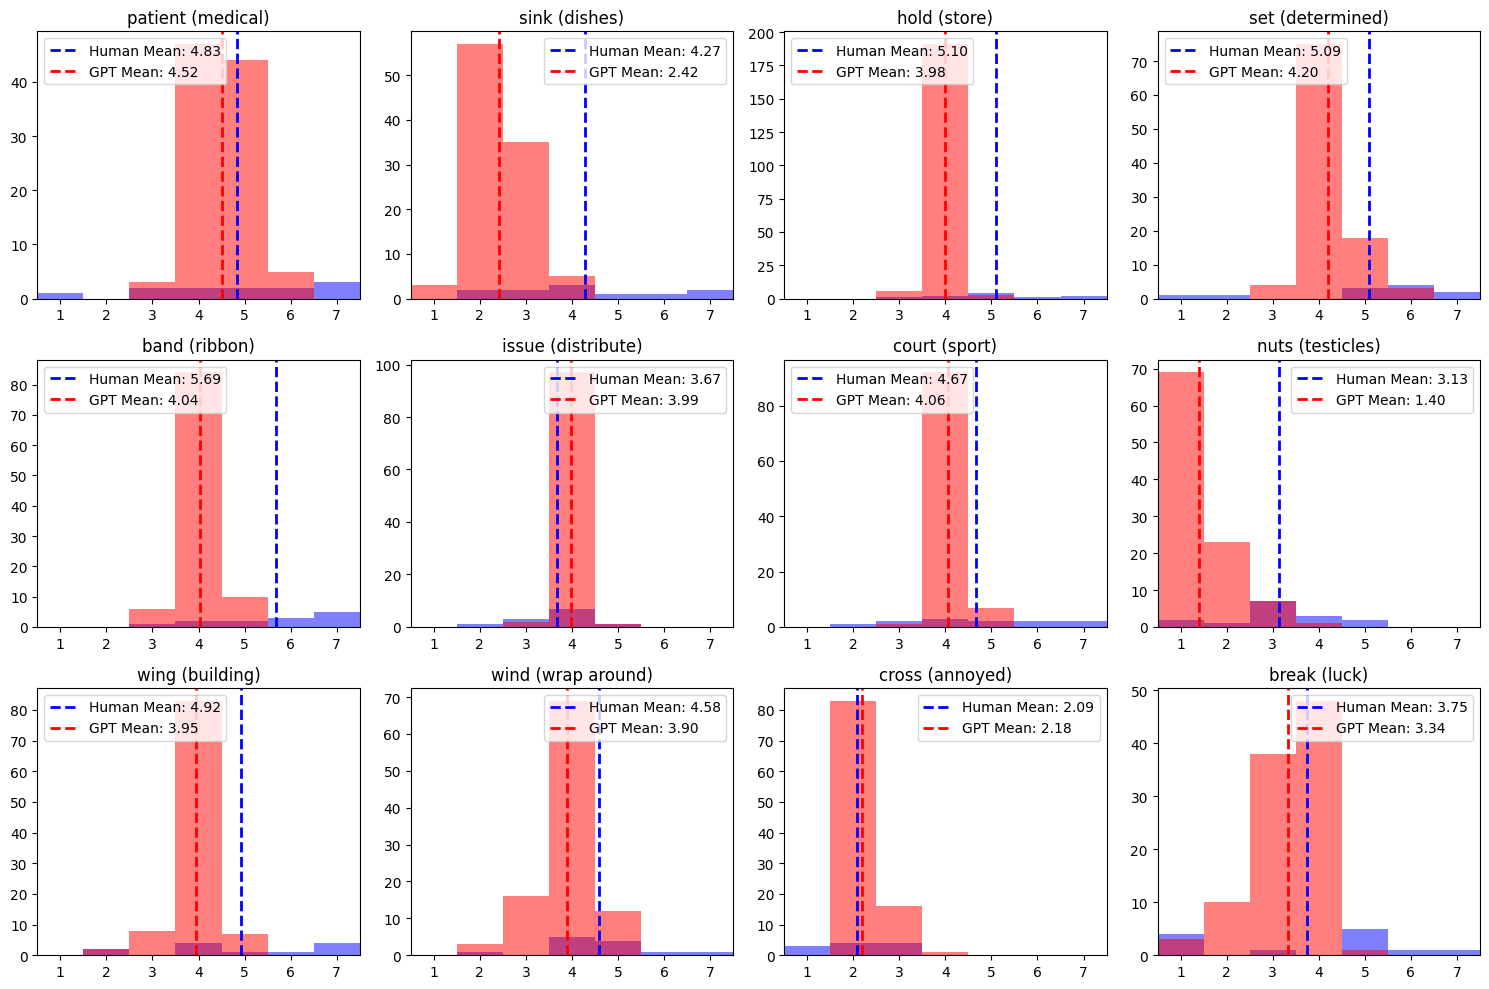

In [36]:
plot_random_words('glasgow_valence.csv', 'gpt_valence_ratings.csv')

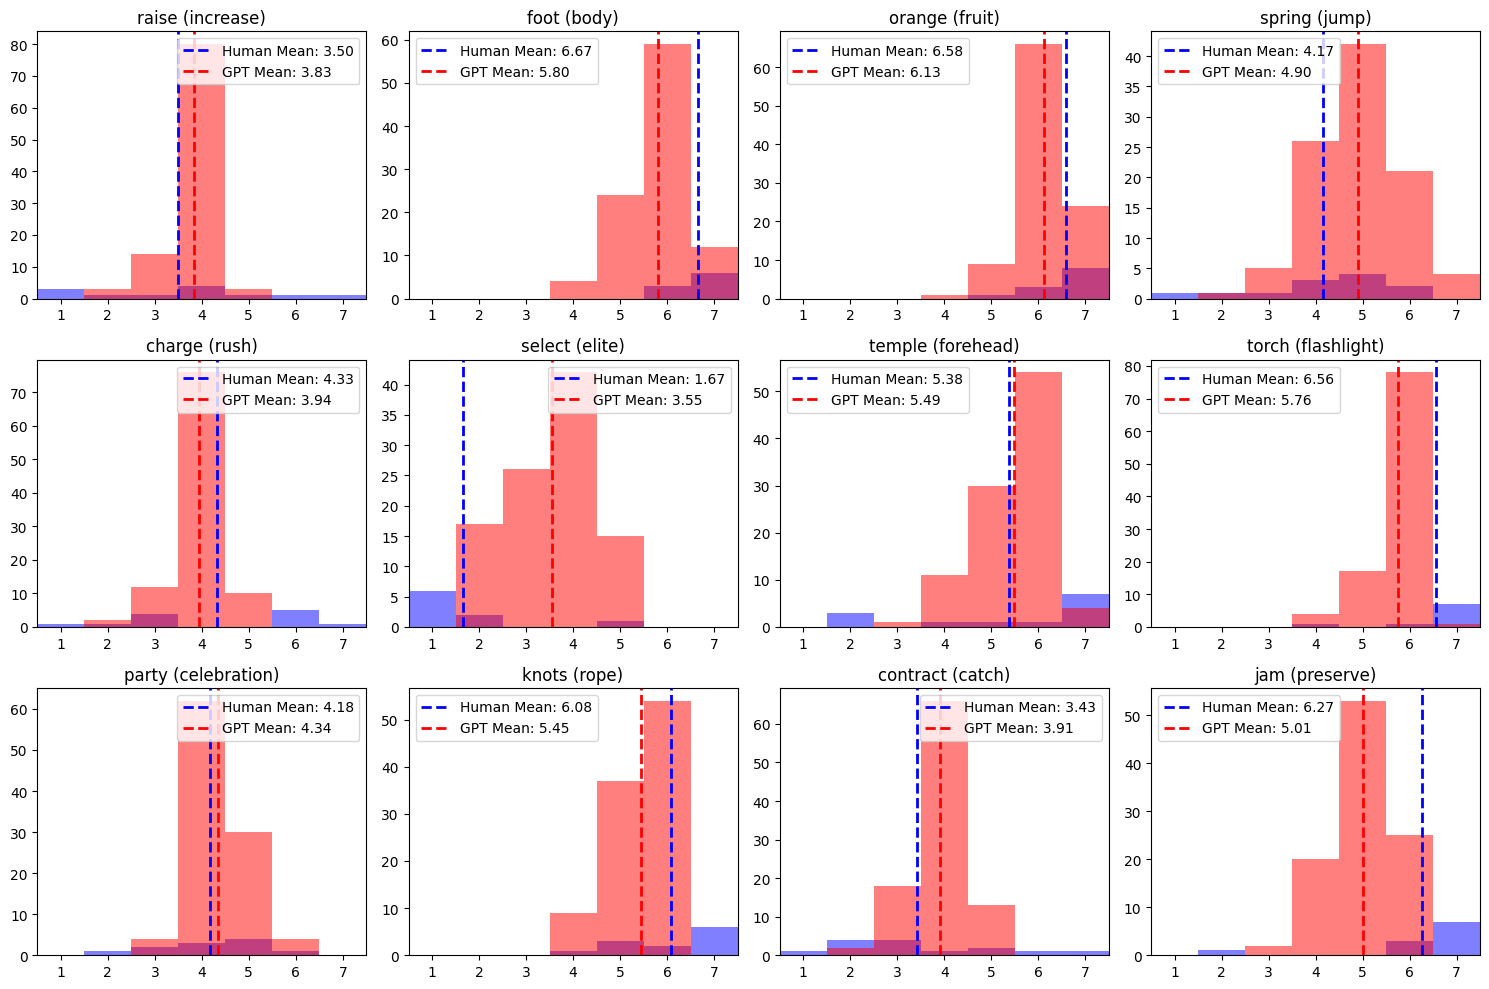

In [40]:
plot_random_words('glasgow_concreteness.csv', 'gpt_concreteness_ratings.csv')

In [41]:
def safe_log(value, min_value=1e-10):
    """
    Return np.log of a value, but the value must be 1e-10 or higher.
    """
    return np.log(max(value, min_value))

def get_likelihood(word, human_ratings, gpt_ratings):
    """
    Given the human and GPT ratings of a word, calculate the log likelihood of 
    receiving the human rating distribution.
    """
    gpt_word = gpt_ratings[gpt_ratings['word'] == word]
    human_word = human_ratings[human_ratings['word'] == word]
    
    gpt_dist = gpt_word['rating'].value_counts(normalize=True)
    gpt_dist = {i: gpt_dist.get(i, 0) for i in range(1, 8)}
    
    likelihood = np.sum(
        human_word['rating'].apply(lambda x: safe_log(gpt_dist.get(x, 1e-10)))
    )
    return likelihood

UNIFORM_DIST = {i: 1/7 for i in range(1, 8)}

def get_uniform_likelihood(word, human_ratings):
    """
    Get the log likelihood of receiving the human rating distribution
    given a uniform likelihood (the null likelihood).
    """
    human_word = human_ratings[human_ratings['word'] == word]
    
    likelihood = np.sum(
        human_word['rating'].apply(lambda x: safe_log(UNIFORM_DIST.get(x, 1e-10)))
    )
    return likelihood

def get_likelihood_results(human_filename, gpt_filename):
    """
    Gather information about GPT-likelihood, null likelihood, relative likelihood, and significance.
    Save this info into a df.
    """
    human_ratings, wordlist = get_human_ratings(human_filename)
    gpt_ratings = get_gpt_ratings(gpt_filename)
    
    for word in wordlist:
        likelihood = get_likelihood(word, human_ratings, gpt_ratings)
        uniform_likelihood = get_uniform_likelihood(word, human_ratings)
        relative_likelihood = -2 * (uniform_likelihood - likelihood)
        p_value = chi2.sf(relative_likelihood, df=1)
        significance = p_value < 0.05

        results.append({
            'word': word,
            'likelihood': likelihood,
            'uniform_likelihood': uniform_likelihood,
            'relative_likelihood': relative_likelihood,
            'p_value': p_value,
            'significance': significance
        })
    
    likelihood_results = pd.DataFrame(results)
    return likelihood_results

In [42]:
# Collect likelihood data for VALENCE
likelihood_valence = get_likelihood_results('glasgow_valence.csv', 'gpt_valence_ratings.csv')
likelihood_valence['significance'].value_counts(normalize=True)

False    0.966705
True     0.033295
Name: significance, dtype: float64

In [43]:
# Collect likelihood data for VALENCE
likelihood_concreteness = get_likelihood_results('glasgow_concreteness.csv', 'gpt_concreteness_ratings.csv')
likelihood_concreteness['significance'].value_counts(normalize=True)

False    0.967623
True     0.032377
Name: significance, dtype: float64

Unfortunately, for both valence and concreteness, the vast majority of words are not significantly more likely to come from a GPT-distribution than the null distribution. This doesn't seem to change with different temperature settings either.

Looking at the plots above, it is clear that GPT ratings are much less variable than human responses. I am curious what the human distribution would look like with a much larger sample size, and whether or not it would take on a much more centered spike shape like the GPT ratings.